In [1]:
# Install required packages
!pip install requests beautifulsoup4 pandas numpy spacy

# Required imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import json
import spacy
from typing import Dict, List, Optional
import logging
import re

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load spacy model
nlp = spacy.load('en_core_web_sm')

In [2]:
import requests
import json

def fetch_raw_uk_data():
    url = "https://www.gov.uk/api/content/foreign-travel-advice/kenya"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        print("\nRaw UK Advisory Data Sample:")
        print(json.dumps(data, indent=2)[:1000])  # Print first 1000 chars
        return data
    else:
        print(f"Error fetching data: Status code {response.status_code}")
        return None

# Test the raw fetch
uk_raw = fetch_raw_uk_data()


Raw UK Advisory Data Sample:
{
  "analytics_identifier": null,
  "base_path": "/foreign-travel-advice/kenya",
  "content_id": "47d7619a-8621-49bc-8e67-75e06b3fb610",
  "description": "FCDO travel advice for Kenya. Includes safety and security, insurance, entry requirements and legal differences. ",
  "details": {
    "alert_status": [
      "avoid_all_but_essential_travel_to_parts"
    ],
    "change_description": "Removal of information about a US alert on increased caution in Kenya and about disruptions due to ongoing strike action  ('Warnings and insurance' page).",
    "change_history": [
      {
        "note": "Latest update: Summary \u2013 addition of information on recent kidnapping incident; Health Section \u2013 revised guidance on sources of health information before travel",
        "public_timestamp": "2018-11-27T11:15:57.976Z"
      },
      {
        "note": "Latest update: Summary - there are reports of an incident in the Riverside area of Nairobi; if you\u2019re able 

In [3]:
def process_uk_data(raw_data):
    """
    Process UK advisory data with enhanced date extraction from change_history.
    Matches notifications to their corresponding dates while maintaining the existing structure.
    """
    if not raw_data:
        return None

    # Initialize storage for our processed data
    risk_areas = {}
    details = raw_data.get('details', {})

    # Extract change history for date matching
    change_history = details.get('change_history', [])

    # Create a mapping of content snippets to their dates
    date_mapping = {}
    for change in change_history:
        note = change.get('note', '').lower()
        timestamp = change.get('public_timestamp', '')
        if timestamp:
            # Convert timestamp to date only (YYYY-MM-DD)
            date = timestamp[:10]
            # Store keywords from the note with their associated date
            words = note.split()
            for i in range(len(words)):
                if i + 2 < len(words):
                    # Store 3-word sequences as keys for better matching
                    key = ' '.join(words[i:i+3])
                    date_mapping[key] = date

    # Convert details to string for processing
    content = str(details)

    # Process each location
    for location in [
            'Nairobi', 'Mombasa', 'Lamu', 'Garissa', 'Mandera', 'Wajir', 'Turkana',
            'West Pokot', 'Elgeyo-Marakwet', 'Baringo', 'Eastleigh', 'Kibera',
            'Kisumu', 'Nakuru', 'Somalia border', 'Ethiopian border', 'South Sudan border', 'Chesongoch', 'Sekerot', 'Cheptulel', 'Ngoron', 'Kolowa',
            'Apuke', 'Kases', 'Sekerot', 'Chesegon' , 'Elgeyo-Marakwet', 'Uasin Gishu', 'Nakuru', 'West Pokot', 'Baringo', 'aElgeyo Marakwet', 'Trans Nzoia']  :
        if location.lower() in content.lower():
            # Extract the surrounding context
            loc_idx = content.lower().find(location.lower())
            start_idx = max(0, loc_idx - 100)
            end_idx = min(len(content), loc_idx + 100)
            location_content = content[start_idx:end_idx]

            # Find the most relevant date for this content
            notification_date = None
            for key in date_mapping:
                if key in location_content.lower():
                    notification_date = date_mapping[key]
                    break

            # If no specific date found, use the most recent date
            if not notification_date and change_history:
                notification_date = change_history[0]['public_timestamp'][:10]

            risk_areas[location] = {
                'risk_level': 'High Risk' if 'avoid' in location_content.lower() else 'Exercise Caution',
                'key_concerns': ['terrorism'] if 'terror' in location_content.lower() else ['general'],
                'evidence': [location_content],
                'notification_date': notification_date  # Add the notification date to our output
            }

    return risk_areas

# Process and display results
if uk_raw:
    risk_areas = process_uk_data(uk_raw)
    print("\nExtracted Risk Areas:")
    print(json.dumps(risk_areas, indent=2))


Extracted Risk Areas:
{
  "Nairobi": {
    "risk_level": "Exercise Caution",
    "key_concerns": [
      "general"
    ],
    "evidence": [
      "76Z'}, {'note': \"Latest update: Summary - there are reports of an incident in the Riverside area of Nairobi; if you\u2019re able to do so safely, consider leaving the area; if you're caught up in the incid"
    ],
    "notification_date": "2020-01-05"
  },
  "Mombasa": {
    "risk_level": "Exercise Caution",
    "key_concerns": [
      "general"
    ],
    "evidence": [
      "nwide curfew and containment periods suspending travel in and out of the Nairobi Metropolitan Area, Mombasa, Kwale and Kilifi (\u2018Coronavirus\u2019 page)', 'public_timestamp': '2020-04-26T10:29:56.000Z'}, {'"
    ],
    "notification_date": "2020-05-16"
  },
  "Lamu": {
    "risk_level": "Exercise Caution",
    "key_concerns": [
      "terrorism"
    ],
    "evidence": [
      "date: Terrorism - Following a terrorist attack on 5 January on a military camp at Manda

In [4]:
def create_uk_advisory_data(raw_data, risk_areas):
    if not raw_data or not risk_areas:
        return None

    advisory_data = {
        'source': 'UK',
        'last_updated': raw_data.get('public_updated_at'),
        'details': {
            'risk_analysis': {
                'risk_areas': risk_areas
            }
        },
        'status': 'success'
    }

    # Create DataFrame for display
    rows = []
    for area, details in risk_areas.items():
        rows.append({
            'Region': area,
            'Risk_Level': details['risk_level'],
            'Risk_Type': ', '.join(details['key_concerns']),
            'Source': 'UK',
            'Last_Updated': raw_data.get('public_updated_at'),
            'Evidence': details['evidence'][0][:100] + '...' if details['evidence'] else ''
        })

    df = pd.DataFrame(rows)
    print("\nUK Travel Advisory Analysis:")
    print("=" * 80)
    print(df.to_string(index=False))

    return advisory_data

# Create final output
if uk_raw and risk_areas:
    uk_data = create_uk_advisory_data(uk_raw, risk_areas)


UK Travel Advisory Analysis:
         Region       Risk_Level Risk_Type Source              Last_Updated                                                                                                Evidence
        Nairobi Exercise Caution   general     UK 2024-11-04T12:48:11+00:00 76Z'}, {'note': "Latest update: Summary - there are reports of an incident in the Riverside area of ...
        Mombasa Exercise Caution   general     UK 2024-11-04T12:48:11+00:00 nwide curfew and containment periods suspending travel in and out of the Nairobi Metropolitan Area, ...
           Lamu Exercise Caution terrorism     UK 2024-11-04T12:48:11+00:00 date: Terrorism - Following a terrorist attack on 5 January on a military camp at Manda Airstrip in ...
        Garissa Exercise Caution   general     UK 2024-11-04T12:48:11+00:00 ential travel to:</p>\n\n<ul>\n  <li>within 60km of Kenya’s border with Somalia</li>\n  <li>Eastern ...
        Mandera Exercise Caution   general     UK 2024-11-04T12:48:11+

In [5]:
# Import required packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import json
import spacy
from typing import Dict, List, Optional
import logging
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import time

# Configure logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Create a logger for this module
logger = logging.getLogger('travel_advisory')

# Test logging setup
logger.info("Logging configuration completed")

# Load spaCy model with logging
try:
    nlp = spacy.load('en_core_web_sm')
    logger.info("Successfully loaded spaCy model")
except Exception as e:
    logger.error(f"Failed to load spaCy model: {e}")
    raise

# Initialize geopy geocoder with logging
try:
    geolocator = Nominatim(user_agent="travel_advisory_analyzer")
    logger.info("Successfully initialized geocoder")
except Exception as e:
    logger.error(f"Failed to initialize geocoder: {e}")
    raise

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def fetch_kenya_advisory():
    """
    Updated function to fetch Kenya travel advisory data using the correct HTML structure.
    """
    url = "https://travel.state.gov/content/travel/en/traveladvisories/traveladvisories/kenya-travel-advisory.html"
    print(f"\nAttempting to fetch data from: {url}")

    try:
        response = requests.get(url)
        print(f"\nResponse status code: {response.status_code}")

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Try to get content from different possible locations
            content_areas = []

            # Look for emergency alerts
            emergency_alert = soup.find('div', class_='tsg-rwd-emergency-alert-text')
            if emergency_alert:
                print("\nFound emergency alert content:")
                print("-" * 80)
                print(emergency_alert.get_text().strip()[:500])
                content_areas.append(emergency_alert.get_text().strip())

            # Look for main content
            main_content = soup.find('div', class_='contentbody')
            if main_content:
                print("\nFound main content:")
                print("-" * 80)
                print(main_content.get_text().strip()[:500])
                content_areas.append(main_content.get_text().strip())

            # Try alternative content location
            alt_content = soup.find('div', class_='tsg-rwd-main-copy-body-frame')
            if alt_content:
                print("\nFound content in main copy body:")
                print("-" * 80)
                print(alt_content.get_text().strip()[:500])
                content_areas.append(alt_content.get_text().strip())

            if content_areas:
                # Combine all found content
                full_content = "\n\n".join(content_areas)
                print("\nTotal content length:", len(full_content))
                return full_content
            else:
                print("\nNo content found in expected locations.")

                # Print some debug info about the page structure
                print("\nPage sections found:")
                for section in soup.find_all('div', class_='section'):
                    print(f"- Section with classes: {section.get('class')}")

                return None

        else:
            print(f"\nFailed to access webpage. Status code: {response.status_code}")
            return None

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        return None

if __name__ == "__main__":
    print("\nKENYA TRAVEL ADVISORY TEST")
    print("=" * 80)

    content = fetch_kenya_advisory()

    if content:
        print("\nSUCCESS: Retrieved content!")
        print("\nWould you like to analyze the content for specific locations? (y/n)")
        response = input()
        if response.lower() == 'y':
            # Look for mentions of our target locations
            target_locations = [
            'Nairobi', 'Mombasa', 'Lamu', 'Garissa', 'Mandera', 'Wajir', 'Turkana',
            'West Pokot', 'Elgeyo-Marakwet', 'Baringo', 'Eastleigh', 'Kibera',
            'Kisumu', 'Nakuru', 'Somalia border', 'Ethiopian border', 'South Sudan border', 'Chesongoch', 'Sekerot', 'Cheptulel', 'Ngoron', 'Kolowa',
            'Apuke', 'Kases', 'Sekerot', 'Chesegon', 'Elgeyo-Marakwet', 'Uasin Gishu', 'Nakuru', 'West Pokot', 'Baringo', 'Elgeyo Marakwet', 'Trans Nzoia'
        ]


            print("\nAnalyzing content for target locations:")
            print("-" * 80)
            for location in target_locations:
                if location.lower() in content.lower():
                    start_idx = content.lower().find(location.lower())
                    # Get some context around the mention
                    context = content[max(0, start_idx-100):min(len(content), start_idx+200)]
                    print(f"\nFound mention of {location}:")
                    print(context.strip())
                    print("-" * 40)
    else:
        print("\nFAILED: Could not retrieve content. Check the messages above for details.")


KENYA TRAVEL ADVISORY TEST

Attempting to fetch data from: https://travel.state.gov/content/travel/en/traveladvisories/traveladvisories/kenya-travel-advisory.html

Response status code: 200

Found emergency alert content:
--------------------------------------------------------------------------------
Reissued with obsolete COVID-19 page links removed.
Exercise increased caution in Kenya due to crime, terrorism, civil unrest, and kidnapping.  Some areas have increased risk.  Read the entire Travel Advisory.
Do Not Travel to:
Kenya-Somalia border counties and some coastal areas, due to terrorism and kidnapping.
Areas of Turkana County, due to crime.
Reconsider Travel to:
Nairobi neighborhoods of Eastleigh and Kibera, due to crime and kidnapping.
Certain areas of Laikipia County, due to crimina

Found main content:
--------------------------------------------------------------------------------
A
B
C
D
E
F




G
H
I
J
K
L




M
N
O
P
Q
R




S
T
U
V
W
X




Y
Z
All


 Filter Countries 


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from typing import Dict, List, Tuple
import time
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from datetime import datetime

class KenyaTravelAdvisoryParser:
    """
    A comprehensive parser for travel advisories about Kenya from multiple sources.
    Handles both US and Australian government advisory websites.
    """

    def __init__(self):
        # Define risk levels for both advisory systems
        self.us_risk_levels = {
            "Do Not Travel": 4,
            "Reconsider Travel": 3,
            "Exercise Increased Caution": 2,
            "Exercise Normal Precautions": 1
        }

        self.au_risk_levels = {
            "Do not travel": 4,
            "Reconsider your need to travel": 3,
            "Exercise a high degree of caution": 2,
            "Exercise normal safety precautions": 1
        }

        # Kenya locations to track
        self.known_locations = [
            'Nairobi', 'Mombasa', 'Lamu', 'Garissa', 'Mandera', 'Wajir', 'Turkana',
            'West Pokot', 'Elgeyo-Marakwet', 'Baringo', 'Eastleigh', 'Kibera',
            'Kisumu', 'Nakuru', 'Somalia border', 'Ethiopian border', 'South Sudan border', 'Chesongoch', 'Sekerot', 'Cheptulel', 'Ngoron', 'Kolowa',
            'Apuke', 'Kases', 'Sekerot', 'Chesegon', 'Elgeyo-Marakwet', 'Uasin Gishu', 'Nakuru', 'West Pokot', 'Baringo', 'Elgeyo Marakwet', 'Trans Nzoia'
        ]

        # Set up session with retry strategy
        self.session = self._create_session()

    def _create_session(self):
        """Create a session with retry strategy and proper headers."""
        session = requests.Session()

        # Configure retry strategy
        retry_strategy = Retry(
            total=3,  # number of retries
            backoff_factor=1,  # wait 1, 2, 4 seconds between retries
            status_forcelist=[429, 500, 502, 503, 504]
        )

        # Apply retry strategy to session
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session.mount("https://", adapter)
        session.mount("http://", adapter)

        # Set default headers
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5'
        })

        return session

    def fetch_us_advisory(self):
        """Fetch and parse the US travel advisory for Kenya."""
        print("\nFetching US Travel Advisory...")
        url = "https://travel.state.gov/content/travel/en/traveladvisories/traveladvisories/kenya-travel-advisory.html"

        try:
            response = self.session.get(url, timeout=10)
            print(f"US Advisory Status Code: {response.status_code}")

            if response.status_code == 200:
                return self._parse_us_content(response.text)
            return pd.DataFrame()

        except Exception as e:
            print(f"Error fetching US advisory: {e}")
            return pd.DataFrame()

    def fetch_au_advisory(self):
        """Fetch and parse the Australian travel advisory for Kenya."""
        print("\nFetching Australian Travel Advisory...")
        url = "https://www.smartraveller.gov.au/destinations/africa/kenya"

        try:
            response = self.session.get(url, timeout=10)
            print(f"Australian Advisory Status Code: {response.status_code}")

            if response.status_code == 200:
                return self._parse_au_content(response.text)
            return pd.DataFrame()

        except Exception as e:
            print(f"Error fetching Australian advisory: {e}")
            return pd.DataFrame()

    def _parse_us_content(self, html_content: str) -> pd.DataFrame:
        """Parse US advisory content and extract location data."""
        soup = BeautifulSoup(html_content, 'html.parser')
        locations_data = []

        # Find main content sections
        content_sections = soup.find_all(['div'], class_=['contentbody', 'tsg-rwd-emergency-alert-text'])

        for section in content_sections:
            text = section.get_text()

            # Process different risk level sections
            for risk_level in self.us_risk_levels.keys():
                if risk_level.lower() in text.lower():
                    # Extract locations and context for this risk level
                    for location in self.known_locations:
                        if location.lower() in text.lower():
                            context = self._get_context(text, location)
                            reason = self._extract_reason(context)

                            locations_data.append({
                                'Location': location,
                                'Risk_Level': risk_level,
                                'Source': 'US State Department',
                                'Reason': reason,
                                'Context': context[:200],  # Limit context length
                                'Last_Updated': datetime.now().strftime('%Y-%m-%d')
                            })

        return pd.DataFrame(locations_data)

    def _parse_au_content(self, html_content: str) -> pd.DataFrame:
        """Parse Australian advisory content and extract location data."""
        soup = BeautifulSoup(html_content, 'html.parser')
        locations_data = []

        # Find main content
        main_content = soup.find('main') or soup.find('div', class_='main-content')

        if main_content:
            text = main_content.get_text()

            # Extract overall advisory level
            overall_level = "Exercise normal safety precautions"
            for level in self.au_risk_levels.keys():
                if level.lower() in text.lower():
                    overall_level = level
                    break

            # Find mentions of specific locations
            for location in self.known_locations:
                if location.lower() in text.lower():
                    context = self._get_context(text, location)
                    reason = self._extract_reason(context)

                    # Determine specific risk level for this location
                    location_level = overall_level
                    for level in self.au_risk_levels.keys():
                        if level.lower() in context.lower():
                            location_level = level
                            break

                    locations_data.append({
                        'Location': location,
                        'Risk_Level': location_level,
                        'Source': 'Australian Government',
                        'Reason': reason,
                        'Context': context[:200],  # Limit context length
                        'Last_Updated': datetime.now().strftime('%Y-%m-%d')
                    })

        return pd.DataFrame(locations_data)

    def _get_context(self, text: str, location: str) -> str:
        """Extract context around a location mention."""
        try:
            loc_index = text.lower().index(location.lower())
            start = max(0, loc_index - 100)
            end = min(len(text), loc_index + 200)
            return text[start:end]
        except ValueError:
            return ""

    def _extract_reason(self, context: str) -> str:
        """Extract the reason for the advisory from context."""
        reason_patterns = [
            r"due to (?P<reason>[^\.]+)",
            r"because of (?P<reason>[^\.]+)",
            r"risk(?:s)? of (?P<reason>[^\.]+)"
        ]

        for pattern in reason_patterns:
            match = re.search(pattern, context, re.IGNORECASE)
            if match:
                return match.group('reason').strip()
        return "No specific reason provided"

    def create_combined_analysis(self):
        """Create a combined analysis from both US and Australian advisories."""
        print("\nCreating combined travel advisory analysis...")

        # Fetch both advisories
        us_df = self.fetch_us_advisory()
        au_df = self.fetch_au_advisory()

        # Combine the dataframes
        combined_df = pd.concat([us_df, au_df], ignore_index=True)

        if not combined_df.empty:
            # Sort by location and risk level
            combined_df = combined_df.sort_values(['Location', 'Risk_Level'])

            # Remove duplicates while keeping highest risk level for each location
            combined_df = combined_df.sort_values('Risk_Level').drop_duplicates(['Location', 'Source'], keep='last')

            print("\nAnalysis completed successfully!")
            return combined_df
        else:
            print("\nNo advisory data could be processed.")
            return pd.DataFrame()

# Run the analysis
if __name__ == "__main__":
    print("\nKENYA TRAVEL ADVISORY ANALYSIS")
    print("=" * 80)

    # Create parser and run analysis
    parser = KenyaTravelAdvisoryParser()
    df = parser.create_combined_analysis()

    if not df.empty:
        # Display results
        print("\nDetailed Advisory Analysis:")
        print("-" * 80)
        print(df.to_string(index=False))

        # Save to CSV
        filename = 'kenya_combined_advisory_analysis.csv'
        df.to_csv(filename, index=False)
        print(f"\nResults saved to '{filename}'")

        # Print summary statistics
        print("\nSummary by Source:")
        print(df.groupby('Source')['Risk_Level'].value_counts())
    else:
        print("\nNo data could be retrieved. Please check your internet connection and try again.")


KENYA TRAVEL ADVISORY ANALYSIS

Creating combined travel advisory analysis...

Fetching US Travel Advisory...
US Advisory Status Code: 200

Fetching Australian Travel Advisory...
Australian Advisory Status Code: 200

Analysis completed successfully!

Detailed Advisory Analysis:
--------------------------------------------------------------------------------
       Location                     Risk_Level                Source                                                                                                                                                                                             Reason                                                                                                                                                                                                              Context Last_Updated
           Lamu                  Do not travel Australian Government                                                                                 

In [8]:
# Import all required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import re
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

class KenyaTravelAdvisoryParser:
    def __init__(self):
        # Define risk levels for both advisory systems
        self.us_risk_levels = {
            "Do Not Travel": 4,
            "Reconsider Travel": 3,
            "Exercise Increased Caution": 2,
            "Exercise Normal Precautions": 1
        }

        self.au_risk_levels = {
            "Do not travel": 4,
            "Reconsider your need to travel": 3,
            "Exercise a high degree of caution": 2,
            "Exercise normal safety precautions": 1
        }

        # Kenya locations to track
        self.known_locations = [
            'Nairobi', 'Mombasa', 'Lamu', 'Garissa', 'Mandera', 'Wajir', 'Turkana',
            'West Pokot', 'Elgeyo-Marakwet', 'Baringo', 'Eastleigh', 'Kibera',
            'Kisumu', 'Nakuru', 'Somalia border', 'Ethiopian border', 'South Sudan border', 'Chesongoch', 'Sekerot', 'Cheptulel', 'Ngoron', 'Kolowa',
            'Apuke', 'Kases', 'Sekerot', 'Chesegon', 'Elgeyo-Marakwet', 'Uasin Gishu', 'Nakuru', 'West Pokot', 'Baringo', 'Elgeyo Marakwet', 'Trans Nzoia'
        ]


        # Set up session with retry strategy
        self.session = self._create_session()

    def _create_session(self):
        """Creates a session with retry strategy and proper headers."""
        session = requests.Session()
        retry_strategy = Retry(
            total=3,
            backoff_factor=1,
            status_forcelist=[429, 500, 502, 503, 504]
        )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session.mount("https://", adapter)
        session.mount("http://", adapter)
        session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5'
        })
        return session

    def fetch_us_advisory(self):
        """Fetches and parses the US travel advisory for Kenya."""
        print("\nFetching US Travel Advisory...")
        url = "https://travel.state.gov/content/travel/en/traveladvisories/traveladvisories/kenya-travel-advisory.html"

        try:
            response = self.session.get(url, timeout=10)
            print(f"US Advisory Status Code: {response.status_code}")

            if response.status_code == 200:
                return self._parse_us_content(response.text)
            return pd.DataFrame()

        except Exception as e:
            print(f"Error fetching US advisory: {e}")
            return pd.DataFrame()

    def fetch_au_advisory(self):
        """Fetches and parses the Australian travel advisory for Kenya."""
        print("\nFetching Australian Travel Advisory...")
        url = "https://www.smartraveller.gov.au/destinations/africa/kenya"

        try:
            # Add specific headers for Australian government website
            self.session.headers.update({
                'Accept-Encoding': 'gzip, deflate, br',
                'Host': 'www.smartraveller.gov.au'
            })

            response = self.session.get(url, timeout=15)  # Increased timeout
            print(f"Australian Advisory Status Code: {response.status_code}")

            if response.status_code == 200:
                return self._parse_au_content(response.text)
            return pd.DataFrame()

        except Exception as e:
            print(f"Error fetching Australian advisory: {e}")
            return pd.DataFrame()

    def _parse_us_content(self, html_content):
        """Parses US advisory content into structured data."""
        soup = BeautifulSoup(html_content, 'html.parser')
        locations_data = []

        # Process alert text and main content
        for section in soup.find_all(['div'], class_=['contentbody', 'tsg-rwd-emergency-alert-text']):
            text = section.get_text()

            for risk_level in self.us_risk_levels.keys():
                if risk_level.lower() in text.lower():
                    context_start = text.lower().find(risk_level.lower())
                    if context_start != -1:
                        context = text[context_start:context_start + 500]

                        # Find mentioned locations in this context
                        for location in self.known_locations:
                            if location.lower() in context.lower():
                                reason = self._extract_reason(context)
                                locations_data.append({
                                    'Location': location,
                                    'Risk_Level': risk_level,
                                    'Source': 'US State Department',
                                    'Reason': reason,
                                    'Context': context[:200],
                                    'Last_Updated': datetime.now().strftime('%Y-%m-%d')
                                })

        return pd.DataFrame(locations_data)

    def _parse_au_content(self, html_content):
        """Parses Australian advisory content into structured data."""
        soup = BeautifulSoup(html_content, 'html.parser')
        locations_data = []

        # Find main content area
        main_content = soup.find('main') or soup.find('article')
        if main_content:
            text = main_content.get_text()

            # Extract overall advisory level
            overall_level = "Exercise normal safety precautions"
            for level in self.au_risk_levels.keys():
                if level.lower() in text.lower():
                    overall_level = level
                    break

            # Process each location
            for location in self.known_locations:
                if location.lower() in text.lower():
                    # Get context around location mention
                    loc_index = text.lower().find(location.lower())
                    context = text[max(0, loc_index-100):min(len(text), loc_index+300)]

                    # Determine specific risk level for this location
                    location_level = overall_level
                    for level in self.au_risk_levels.keys():
                        if level.lower() in context.lower():
                            location_level = level
                            break

                    reason = self._extract_reason(context)
                    locations_data.append({
                        'Location': location,
                        'Risk_Level': location_level,
                        'Source': 'Australian Government',
                        'Reason': reason,
                        'Context': context[:200],
                        'Last_Updated': datetime.now().strftime('%Y-%m-%d')
                    })

        return pd.DataFrame(locations_data)

    def _extract_reason(self, context):
        """Extracts the reason for the advisory from context."""
        reason_patterns = [
            r"due to (?P<reason>[^\.]+)",
            r"because of (?P<reason>[^\.]+)",
            r"risk(?:s)? of (?P<reason>[^\.]+)"
        ]

        for pattern in reason_patterns:
            match = re.search(pattern, context, re.IGNORECASE)
            if match:
                return match.group('reason').strip()
        return "No specific reason provided"

# Test if needed
if __name__ == "__main__":
    parser = KenyaTravelAdvisoryParser()
    print("\nTesting all advisory sources...")

    us_df = parser.fetch_us_advisory()
    au_df = parser.fetch_au_advisory()

    if not us_df.empty:
        print(f"\nFound {len(us_df)} US advisories")
    if not au_df.empty:
        print(f"\nFound {len(au_df)} Australian advisories")


Testing all advisory sources...

Fetching US Travel Advisory...
US Advisory Status Code: 200

Fetching Australian Travel Advisory...
Australian Advisory Status Code: 200

Found 26 US advisories

Found 16 Australian advisories


In [12]:
def process_uk_data(raw_data):
    """
    Process UK advisory data with enhanced support for multiple locations in single notifications.
    Properly handles cases where multiple locations share the same notification and date.
    """
    if not raw_data:
        return None

    risk_areas = {}
    details = raw_data.get('details', {})
    change_history = details.get('change_history', [])

    # Define all locations we want to track
    locations_to_track = [
            'Nairobi', 'Mombasa', 'Lamu', 'Garissa', 'Mandera', 'Wajir', 'Turkana',
            'West Pokot', 'Elgeyo-Marakwet', 'Baringo', 'Eastleigh', 'Kibera',
            'Kisumu', 'Nakuru', 'Somalia border', 'Ethiopian border', 'South Sudan border', 'Chesongoch', 'Sekerot', 'Cheptulel', 'Ngoron', 'Kolowa',
            'Apuke', 'Kases', 'Sekerot', 'Chesegon', 'Elgeyo-Marakwet', 'Uasin Gishu', 'Nakuru', 'West Pokot', 'Baringo', 'Elgeyo Marakwet', 'Trans Nzoia'
        ]


    # Process each notification in change history
    for change in change_history:
        note = change.get('note', '').lower()
        timestamp = change.get('public_timestamp', '')
        notification_date = timestamp[:10] if timestamp else None

        # Find all locations mentioned in this notification
        found_locations = []
        for location in locations_to_track:
            if location.lower() in note:
                found_locations.append(location)

        # If we found any locations in this notification
        if found_locations:
            # Get the full context of the notification
            context = note

            # Determine risk level and concerns for this notification
            is_high_risk = 'avoid' in context
            is_terrorism = 'terror' in context

            # Create or update entries for all locations found in this notification
            for location in found_locations:
                # If this location doesn't have an entry yet, or this notification is more recent
                if (location not in risk_areas or
                    (notification_date and risk_areas[location].get('notification_date', '') < notification_date)):

                    risk_areas[location] = {
                        'risk_level': 'High Risk' if is_high_risk else 'Exercise Caution',
                        'key_concerns': ['terrorism'] if is_terrorism else ['general'],
                        'evidence': [change.get('note', '')],  # Use the original note text
                        'notification_date': notification_date
                    }

    # Process the main content for any additional mentions
    content = str(details)

    # Add any locations that might be mentioned in the content but not in notifications
    for location in locations_to_track:
        if location.lower() in content.lower() and location not in risk_areas:
            loc_idx = content.lower().find(location.lower())
            start_idx = max(0, loc_idx - 100)
            end_idx = min(len(content), loc_idx + 100)
            location_content = content[start_idx:end_idx]

            # Use the most recent notification date if available
            latest_date = (change_history[0]['public_timestamp'][:10]
                         if change_history else datetime.now().strftime('%Y-%m-%d'))

            risk_areas[location] = {
                'risk_level': 'High Risk' if 'avoid' in location_content.lower() else 'Exercise Caution',
                'key_concerns': ['terrorism'] if 'terror' in location_content.lower() else ['general'],
                'evidence': [location_content],
                'notification_date': latest_date
            }

    return risk_areas

def process_uk_advisory_row(location, details):
    """Helper function to process a single UK advisory row with proper date handling"""
    return {
        'Location': location,
        'Risk_Level': details['risk_level'],
        'Source': 'UK FCDO',
        'Reason': ', '.join(details['key_concerns']),
        'Context': details['evidence'][0][:200] if details.get('evidence') else '',
        'Advisory_Date': details.get('notification_date') or datetime.now().strftime('%Y-%m-%d')
    }

def combine_all_advisories(uk_raw_data):
    """
    Combines advisory data from all three sources with enhanced UK date processing.
    """
    print("\nStarting comprehensive advisory combination process...")

    # Initialize our dataframes list to combine at the end
    dfs_to_combine = []

    # Process UK data with enhanced date handling
    if uk_raw_data:
        uk_rows = []
        risk_areas = process_uk_data(uk_raw_data)
        if risk_areas:
            for location, details in risk_areas.items():
                uk_rows.append(process_uk_advisory_row(location, details))
        uk_df = pd.DataFrame(uk_rows)
        dfs_to_combine.append(uk_df)
        print(f"Processed {len(uk_rows)} UK advisories")
    else:
        print("No UK data available")

    # Create parser for US and Australian data
    parser = KenyaTravelAdvisoryParser()

    # Get US data
    us_df = parser.fetch_us_advisory()
    if not us_df.empty:
        us_df = us_df.rename(columns={'Last_Updated': 'Advisory_Date'})
        dfs_to_combine.append(us_df)
        print(f"Processed {len(us_df)} US advisories")
    else:
        print("No US data available")

    # Get Australian data
    au_df = parser.fetch_au_advisory()
    if not au_df.empty:
        au_df = au_df.rename(columns={'Last_Updated': 'Advisory_Date'})
        dfs_to_combine.append(au_df)
        print(f"Processed {len(au_df)} Australian advisories")
    else:
        print("No Australian data available")

    # Combine all available dataframes
    if dfs_to_combine:
        combined_df = pd.concat(dfs_to_combine, ignore_index=True)

        # Clean up dates
        combined_df['Advisory_Date'] = pd.to_datetime(
            combined_df['Advisory_Date'],
            errors='coerce'
        ).dt.strftime('%Y-%m-%d')

        # Add fetch date
        combined_df['Fetch_Date'] = datetime.now().strftime('%Y-%m-%d')

        # Sort and remove duplicates
        combined_df = combined_df.sort_values(['Location', 'Advisory_Date', 'Source'])
        combined_df = combined_df.drop_duplicates(
            ['Location', 'Source', 'Risk_Level'],
            keep='last'
        )

        return combined_df
    else:
        print("No data available from any source")
        return pd.DataFrame()

# Run the analysis
print("\nKENYA COMBINED TRAVEL ADVISORY ANALYSIS")
print("=" * 80)

if 'uk_raw' in globals():
    combined_df = combine_all_advisories(uk_raw)

    if not combined_df.empty:
        # Display results
        print("\nDetailed Combined Advisory Analysis:")
        print("-" * 80)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)
        print(combined_df.to_string(index=False))

        # Save to CSV
        filename = 'kenya_all_sources_advisory_analysis.csv'
        combined_df.to_csv(filename, index=False)
        print(f"\nResults saved to '{filename}'")

        # Print summary statistics
        print("\nSummary by Source:")
        print(combined_df.groupby(['Source'])['Risk_Level'].value_counts().unstack(fill_value=0))

        print("\nAdvisory Date Range by Source:")
        for source in combined_df['Source'].unique():
            source_data = combined_df[combined_df['Source'] == source]
            print(f"\n{source}:")
            print(f"Earliest: {source_data['Advisory_Date'].min()}")
            print(f"Latest: {source_data['Advisory_Date'].max()}")
    else:
        print("No data could be combined")
else:
    print("Please run the previous cells to load the UK data first")

combined_df.to_csv(f'kenya_travel_advisories_{datetime.now().strftime("%Y%m%d_%H%M")}.csv', index=False)


KENYA COMBINED TRAVEL ADVISORY ANALYSIS

Starting comprehensive advisory combination process...
Processed 14 UK advisories

Fetching US Travel Advisory...
US Advisory Status Code: 200
Processed 26 US advisories

Fetching Australian Travel Advisory...
Australian Advisory Status Code: 200
Processed 16 Australian advisories

Detailed Combined Advisory Analysis:
--------------------------------------------------------------------------------
       Location                 Risk_Level                Source                                                                                                                                                                                             Reason                                                                                                                                                                                                            Context Advisory_Date Fetch_Date
        Baringo           Exercise Caution               UK F

KENYA TRAVEL ADVISORY ANALYSIS

Overall Statistics:
Total number of advisories: 41
Number of unique locations: 16
Number of different sources: 3

Regional Summary:
                 Number_of_Advisories  \
Location                                
Baringo                             2   
Eastleigh                           5   
Elgeyo Marakwet                     2   
Elgeyo-Marakwet                     1   
Garissa                             2   
Kibera                              5   
Kisumu                              1   
Lamu                                2   
Mandera                             2   
Mombasa                             2   
Nairobi                             5   
Nakuru                              1   
Somalia border                      4   
Turkana                             4   
Wajir                               1   
West Pokot                          2   

                                                                                                 

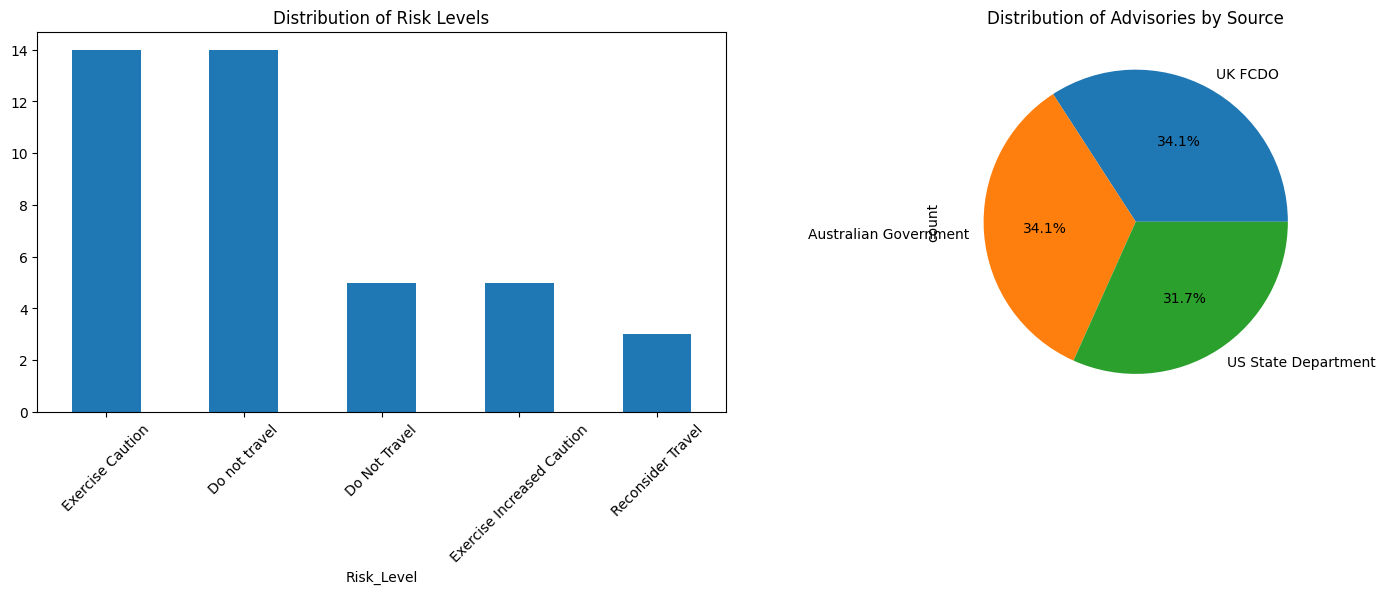

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Read the CSV file
df = pd.read_csv('kenya_travel_advisories_'+datetime.now().strftime("%Y%m%d_%H%M")+'.csv')

def analyze_travel_advisories():
    """
    Provides a comprehensive analysis of travel advisories including regional patterns,
    risk levels, and temporal aspects of the data.
    """
    print("KENYA TRAVEL ADVISORY ANALYSIS")
    print("=" * 80)

    # 1. Basic Statistics
    print("\nOverall Statistics:")
    print(f"Total number of advisories: {len(df)}")
    print(f"Number of unique locations: {df['Location'].nunique()}")
    print(f"Number of different sources: {df['Source'].nunique()}")

    # 2. Regional Analysis
    print("\nRegional Summary:")
    regional_summary = df.groupby('Location').agg({
        'Risk_Level': ['count', lambda x: ', '.join(set(x))],
        'Source': lambda x: ', '.join(set(x)),
        'Reason': lambda x: '; '.join(set(x))
    }).round(2)

    regional_summary.columns = ['Number_of_Advisories', 'Risk_Levels', 'Sources', 'Reasons']
    print(regional_summary)

    # 3. Source Analysis
    print("\nBreakdown by Source:")
    source_summary = df.groupby(['Source', 'Risk_Level']).size().unstack(fill_value=0)
    print(source_summary)

    # 4. Risk Level Analysis
    print("\nRisk Level Distribution:")
    risk_distribution = df['Risk_Level'].value_counts()
    print(risk_distribution)

    # 5. Temporal Analysis for UK Advisories
    uk_data = df[df['Source'] == 'UK FCDO'].copy()
    uk_data['Advisory_Date'] = pd.to_datetime(uk_data['Advisory_Date'])

    if not uk_data.empty:
        print("\nUK Advisory Timeline:")
        uk_timeline = uk_data.sort_values('Advisory_Date')
        for _, row in uk_timeline.iterrows():
            print(f"{row['Advisory_Date'].strftime('%Y-%m-%d')}: {row['Location']} - {row['Risk_Level']}")

    # 6. Major Cities Analysis
    major_cities = ['Nairobi', 'Mombasa']
    print("\nMajor Cities Advisory Analysis:")
    for city in major_cities:
        city_data = df[df['Location'].str.contains(city, case=False, na=False)]
        if not city_data.empty:
            print(f"\n{city} Advisories:")
            print(f"Total advisories: {len(city_data)}")
            print("Risk Levels:", ', '.join(city_data['Risk_Level'].unique()))
            print("Key Concerns:", '; '.join(city_data['Reason'].unique()))

    # 7. Regional Security Pattern Analysis
    print("\nRegional Security Patterns:")
    # Group regions by common security concerns
    security_patterns = df.groupby('Reason').agg({
        'Location': lambda x: ', '.join(set(x)),
        'Risk_Level': lambda x: ', '.join(set(x))
    })
    print(security_patterns)

    # 8. Save Detailed Analysis to CSV
    detailed_summary = pd.DataFrame({
        'Location': df['Location'].unique()
    })

    for source in df['Source'].unique():
        source_data = df[df['Source'] == source]
        detailed_summary[f'{source}_Risk_Levels'] = detailed_summary['Location'].map(
            source_data.groupby('Location')['Risk_Level'].agg(lambda x: ', '.join(set(x)))
        )

    detailed_summary['Latest_Notice_Date'] = detailed_summary['Location'].map(
        df.groupby('Location')['Advisory_Date'].max()
    )

    detailed_summary.to_csv('kenya_advisory_detailed_summary.csv', index=False)
    print("\nDetailed summary saved to 'kenya_advisory_detailed_summary.csv'")

# Run the analysis
analyze_travel_advisories()

# Create visualizations
def create_advisory_visualizations():
    """
    Creates visualizations to help understand patterns in the travel advisory data.
    """
    plt.figure(figsize=(15, 10))

    # 1. Risk Level Distribution
    plt.subplot(2, 2, 1)
    df['Risk_Level'].value_counts().plot(kind='bar')
    plt.title('Distribution of Risk Levels')
    plt.xticks(rotation=45)

    # 2. Advisories by Source
    plt.subplot(2, 2, 2)
    df['Source'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Advisories by Source')

    # Save visualizations
    plt.tight_layout()
    plt.savefig('kenya_advisory_analysis.png')
    print("\nVisualizations saved to 'kenya_advisory_analysis.png'")

# Create visualizations
create_advisory_visualizations()